<a href="https://colab.research.google.com/github/jmestanza/Guia_2_PASA/blob/master/Guia_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/sweep_rapido.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/sweep_lento.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/cuadrada.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/music_original.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/ruido_blanco_c.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/voice_48k.wav"

!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_sweep_rapido.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_sweep_lento.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_cuadrada.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_cassiopeia.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_ruido_blanco.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_voice.wav"
!pip install -U pip setuptools
!ls
clear_output()

import warnings
warnings.filterwarnings("ignore")
from scipy.io.wavfile import read
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import wave, struct, math, random
from IPython.display import Audio
from scipy import signal as sgn
from scipy.linalg import toeplitz
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import ccf
from pycorrelate import ucorrelate
from scipy import linalg
from scipy import signal
from scipy.io.wavfile import write


In [0]:
!pip install soundfile
import soundfile as sf
def fast_plot(data):
    plt.plot(range(len(data)),data)
def normalize(datos):
    return np.interp(datos, (datos.min(), datos.max()), (-1, +1)) #normalizamos
def get_mono_array(stereo_file_name):
    file = read(stereo_file_name)
    fs = file[0]
    datos = np.array(file[1],dtype=float) 
    if len(np.shape(datos))>1: #si tiene dos canales
        ch0 = datos[:, 0]
        ch1 = datos[:, 1]
        datos = (ch0 + ch1)/2  # o lo hacemos mono
    return fs, datos


###Archivos de entrada y sus diferentes sincronizaciones

In [0]:
# Obtenemos los datos de sweep logaritmico
clear_output()

##Ordenes para probar el filtro
Ms = [i for i in range(1,11)]
Ms = np.concatenate((Ms,[10*i for i in range(2,11)]))
Ms = np.concatenate((Ms,[100*i for i in range(2,11)]))
Ms = np.concatenate((Ms,[1000*i for i in range(2,11)]))

##Defino un diccionario con los nombres de archivos de entrada y deseada para cada señal, junto con la diferencia de tiempo para sincronizar
signals = {'lin':['/content/sweep_rapido.wav','/content/grab_sweep_rapido.wav',0.336,7.977],
          'log':['/content/sweep_lento.wav','/content/grab_sweep_lento.wav',0.648,10.936],
          'square':['/content/cuadrada.wav','/content/grab_cuadrada.wav',0.341,7.345],
          'noise':['/content/ruido_blanco.wav','/content/grab_ruido_blanco.wav',0.665, 8.339],
          'voice':['/content/voice_48k.wav','/content/grab_voice.wav',0.636,5.070],
          'music':['/content/music_original.wav','/content/grab_cassiopeia.wav',0.364,7.971]}

In [0]:
def read_wavs(audio_file,grab_file):
  file_name = grab_file
  fs, grab_audio = get_mono_array(file_name)
  grab_audio /= np.max(np.abs(grab_audio),axis=0)
  grab_audio /= np.max(np.abs(grab_audio),axis=0)
  grab_audio = grab_audio - np.mean(grab_audio)
  print("fs de la grabacion ",fs, "nombre", file_name)

  file_name = audio_file
  fs, audio = get_mono_array(file_name)

  audio /= np.max(np.abs(audio),axis=0)
  audio = audio-np.mean(audio)
  print("fs de la audio ",fs, "nombre", file_name)
  return audio,grab_audio,fs

def sync_signals(u,d,init_delay,evLen,fs):
    u = u[int(0):int((evLen)*fs)]
    d = d[int((init_delay)*fs):int((init_delay+evLen)*fs)]
    return u, d

def adjustSignals(fs,u,d):
    ##Agrego ceros si alguna señal tiene diferente tamaño
    diff = len(u) - len(d)
    if(diff > 0):
        d = np.concatenate((d,[0 for _ in range(diff)]))
    elif(diff < 0):
        u = np.concatenate((u,[0 for _ in range(-diff)]))
    
    ##Agrego un segundo de ceros al principio y al final
    uZ = np.array([0 for i in range(0,1*fs)])
    uZ = np.concatenate((uZ,u))
    uZ = np.concatenate((uZ,[0 for i in range(0,1*fs)]))

    dZ = np.array([0 for i in range(0,1*fs)])
    dZ = np.concatenate((dZ,d))
    dZ = np.concatenate((dZ,[0 for i in range(0,1*fs)]))
    return uZ,dZ

def get_estimations(u,d):
    u_f = np.fft.fft(u)
    d_f = np.fft.fft(d)
    
    ##Estimo la autocorrelación
    print("Calculando R...")
    r = np.fft.ifft(u_f * u_f.conj()).real
    r = r[:len(u)//2]/len(u)
    ##Estimo la correlación cruzada
    print("Calculando P...")
    p = np.fft.ifft(u_f * d_f.conj()).real
    p = p[len(u)//2:]/len(u)
    p = np.flip(p)

    ##Energía de la señal deseada
    s2d = np.var(d)
    return r,p,s2d

def get_filter(rx,p,M,sigma2d):
    rx1=rx[0:M]
    p1=p[0:M]
    R = toeplitz(rx1)
# resuelve el sistema R wo = p
    wo = np.dot(linalg.inv(R), p1)
    Jmin = sigma2d - p1.dot(wo)
    return rx1,R,p1,wo,Jmin

def eigenvalues_dist(eigens,sound):
    plt.figure()
    plt.hist(eigens, bins=40)
    plt.title("Distribución de autovalores para entrada : "+ sound)
    plt.ylabel('Autovalores de $R_{xx}$ para  ' + sound, fontsize=14)
    plt.show()


###Entrada Sweep Logarítmico

In [0]:
sound="log"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)


r, p, sigma2d = get_estimations(uZ,dZ)
Jmin = np.zeros(len(Ms))
for i,M in enumerate(Ms):
  r1,R,p1,wo,Jmin[i]= get_filter(r,p,M,sigma2d)

estimado = signal.filtfilt(wo,[1],u)

#aval = linalg.eigvalsh(R)
#eigenvalues_dist(aval,sound)

Calculando R...
Calculando P...


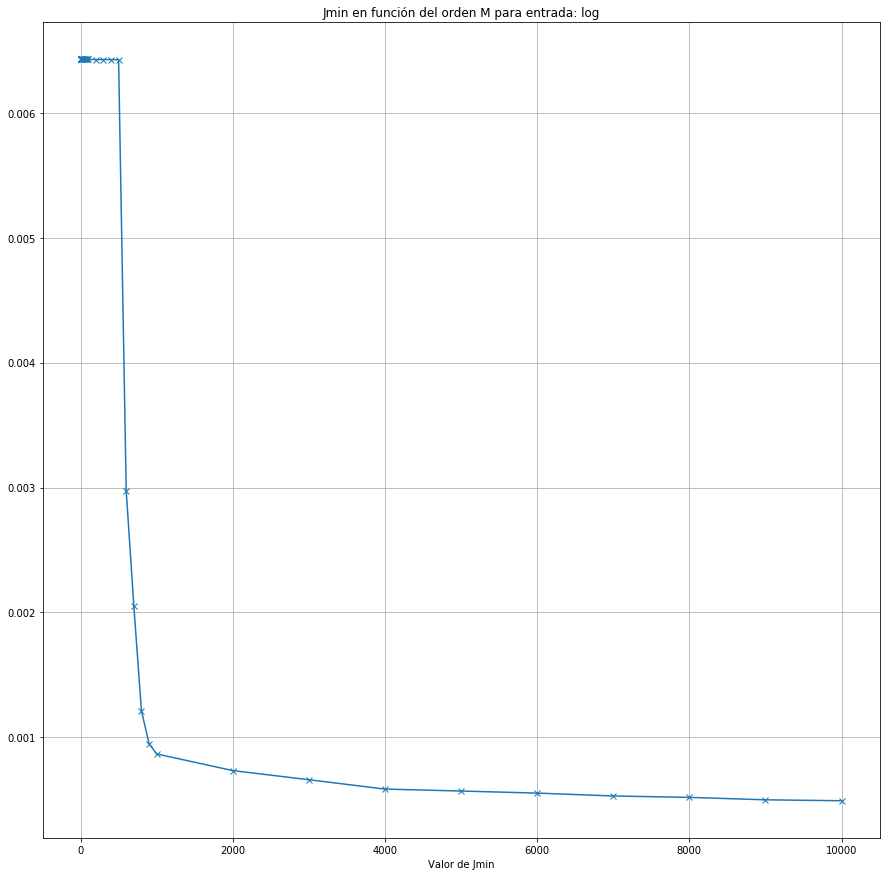

In [0]:
plt.figure(figsize=[15,15])
plt.title("Jmin en función del orden M para entrada: "+ sound)
plt.xlabel("Orden M del filtro")
plt.xlabel("Valor de Jmin")
plt.grid(True)
plt.plot(Ms,Jmin, marker='x')

In [0]:
#ACA ELIJO EL MOPTIMO, CREO QUE HABRIA QUE HARDCODEARLO PARA CADA AUDIO DE ENTRADA
Mopt=Ms[len(Ms)-2]
r1,R1,p1,wo,Jminim= get_filter(r,p,Mopt,sigma2d)
estimado = signal.filtfilt(wo,[1],u)
print("El valor de Epsilon  para el M óptimo es: ",Jminim/sigma2d)

El valor de Epsilon  para el M óptimo es:  0.07758712302682977


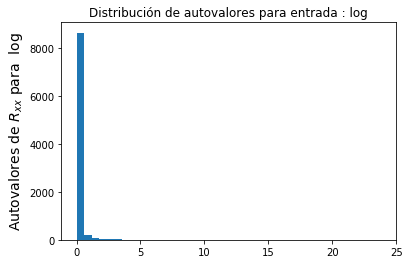

In [0]:
aval = linalg.eigvalsh(R1)
eigenvalues_dist(aval,sound)

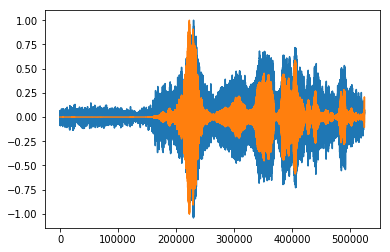

In [0]:
d = d/max(d)
estimado = estimado/max(estimado)
plt.plot(range(len(d)),d)
plt.plot(range(len(estimado)),estimado)
plt.show()

In [0]:
Audio(estimado,rate=fs)

###Entrada Sweep Lineal

In [0]:
sound="lin"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)


r, p, sigma2d = get_estimations(uZ,dZ)
Jmin = np.zeros(len(Ms))
for i,M in enumerate(Ms):
  r1,R,p1,wo,Jmin[i]= get_filter(r,p,M,sigma2d)

estimado = signal.filtfilt(wo,[1],u)


Calculando R...
Calculando P...


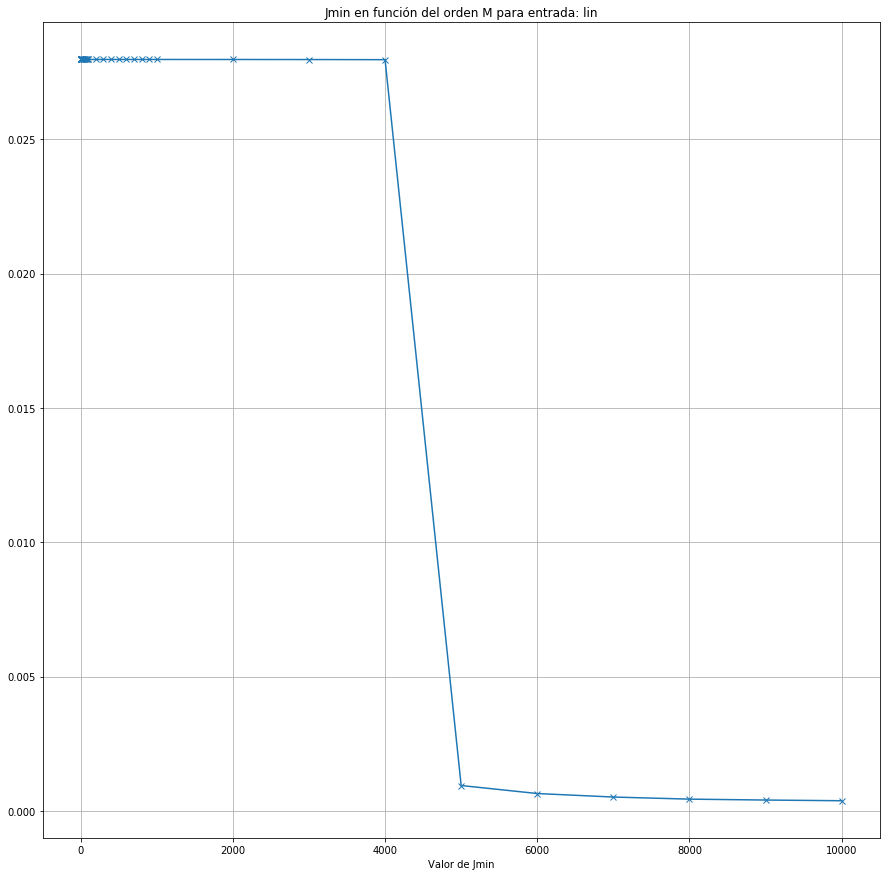

In [0]:
plt.figure(figsize=[15,15])
plt.title("Jmin en función del orden M para entrada: "+ sound)
plt.xlabel("Orden M del filtro")
plt.xlabel("Valor de Jmin")
plt.grid(True)
plt.plot(Ms,Jmin, marker='x')

In [0]:
#ACA ELIJO EL MOPTIMO, CREO QUE HABRIA QUE HARDCODEARLO PARA CADA AUDIO DE ENTRADA
Mopt=Ms[len(Ms)-2]
r1,R1,p1,wo,Jminim= get_filter(r,p,Mopt,sigma2d)
estimado = signal.filtfilt(wo,[1],u)
print("El valor de Epsilon  para el M óptimo es: ",Jminim/sigma2d)

El valor de Epsilon  para el M óptimo es:  0.01464429387613779


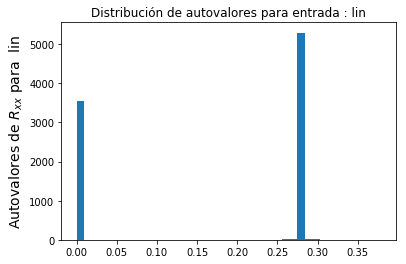

In [0]:
aval = linalg.eigvalsh(R1)
eigenvalues_dist(aval,sound)

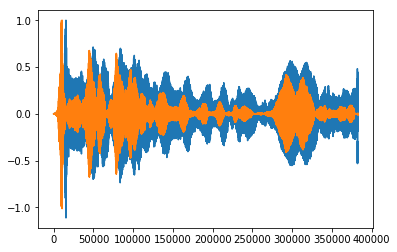

In [0]:
d = d/max(d)
estimado = estimado/max(estimado)
plt.plot(range(len(d)),d)
plt.plot(range(len(estimado)),estimado)
plt.show()

In [0]:
Audio(estimado,rate=fs)

###Entrada Señal Cuadrada

In [0]:
sound="square"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)


r, p, sigma2d = get_estimations(uZ,dZ)
Jmin = np.zeros(len(Ms))
for i,M in enumerate(Ms):
  r1,R,p1,wo,Jmin[i]= get_filter(r,p,M,sigma2d)

estimado = signal.filtfilt(wo,[1],u)


Calculando R...
Calculando P...


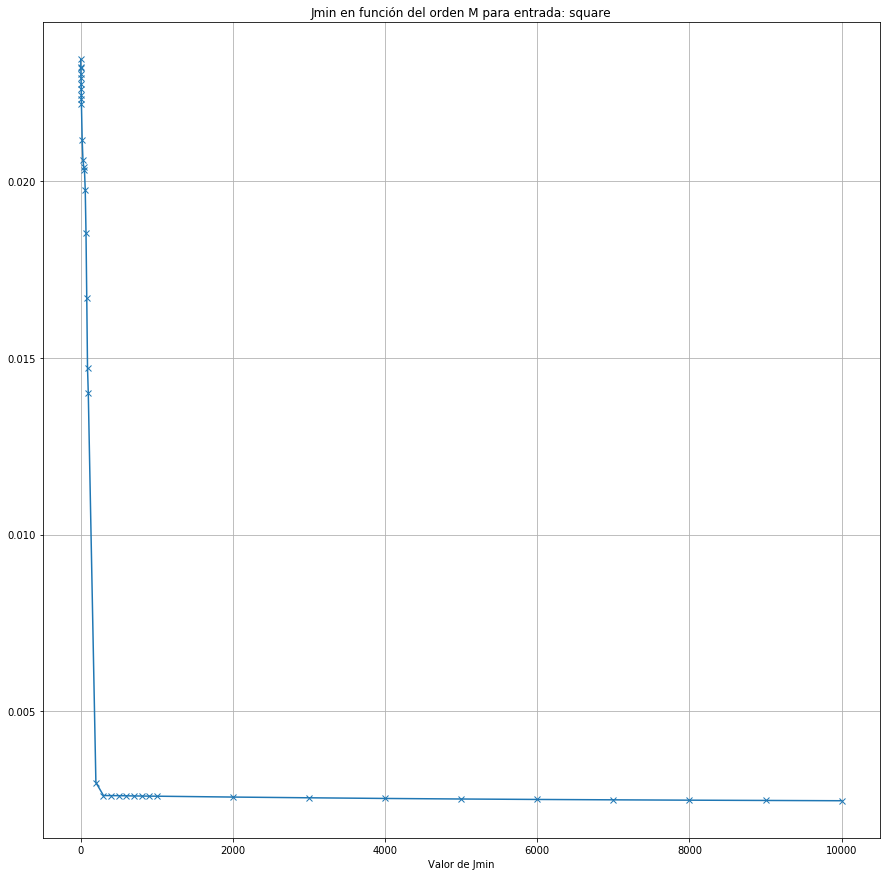

In [0]:
plt.figure(figsize=[15,15])
plt.title("Jmin en función del orden M para entrada: "+ sound)
plt.xlabel("Orden M del filtro")
plt.xlabel("Valor de Jmin")
plt.grid(True)
plt.plot(Ms,Jmin, marker='x')

In [0]:
#ACA ELIJO EL MOPTIMO, CREO QUE HABRIA QUE HARDCODEARLO PARA CADA AUDIO DE ENTRADA
Mopt=Ms[len(Ms)-2]
r1,R1,p1,wo,Jminim= get_filter(r,p,Mopt,sigma2d)
estimado = signal.filtfilt(wo,[1],u)
print("El valor de Epsilon  para el M óptimo es: ",Jminim/sigma2d)

El valor de Epsilon  para el M óptimo es:  0.10517968153568194


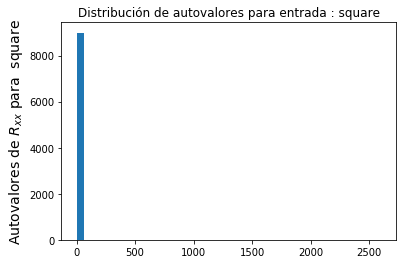

In [0]:
aval = linalg.eigvalsh(R1)
eigenvalues_dist(aval,sound)

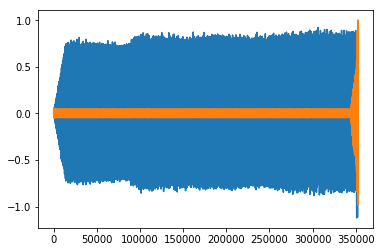

In [0]:
d = d/max(d)
estimado = estimado/max(estimado)
plt.plot(range(len(d)),d)
plt.plot(range(len(estimado)),estimado)
plt.show()

In [0]:
Audio(estimado,rate=fs)

###Entrada Ruido Blanco

In [0]:
sound="noise"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)


r, p, sigma2d = get_estimations(uZ,dZ)
Jmin = np.zeros(len(Ms))
for i,M in enumerate(Ms):
  r1,R,p1,wo,Jmin[i]= get_filter(r,p,M,sigma2d)

estimado = signal.filtfilt(wo,[1],u)


fs de la grabacion  48000 nombre /content/grab_ruido_blanco.wav
fs de la audio  48000 nombre /content/ruido_blanco.wav
Calculando R...
Calculando P...


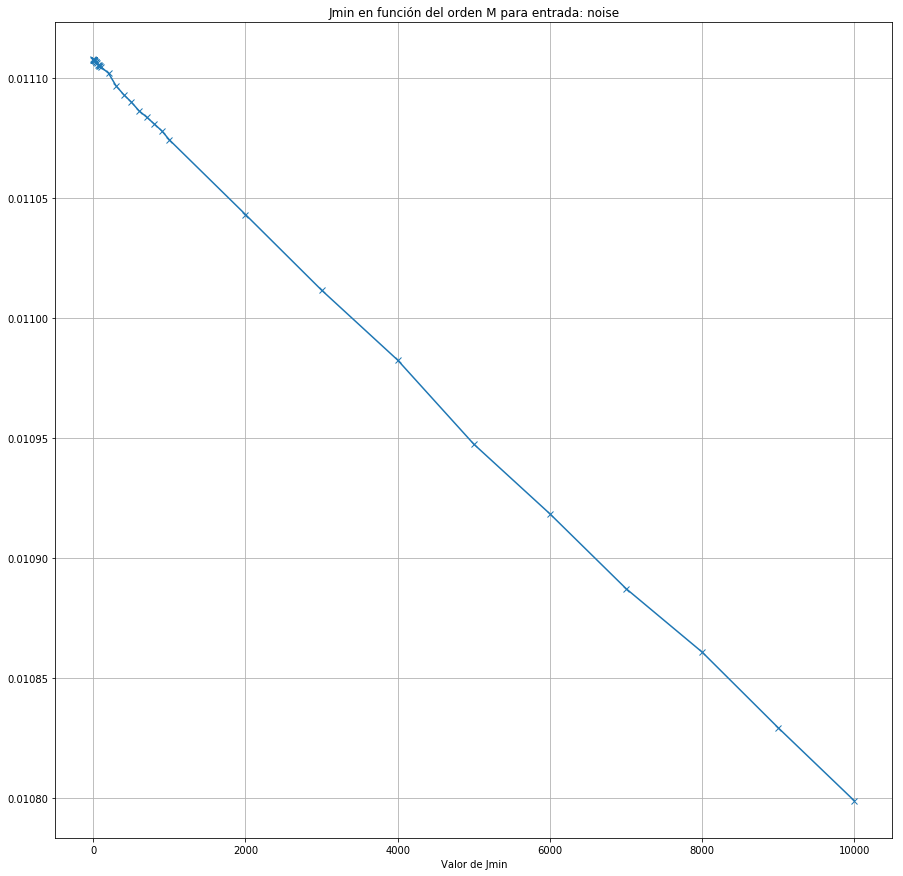

In [0]:
plt.figure(figsize=[15,15])
plt.title("Jmin en función del orden M para entrada: "+ sound)
plt.xlabel("Orden M del filtro")
plt.xlabel("Valor de Jmin")
plt.grid(True)
plt.plot(Ms,Jmin, marker='x')

In [0]:
#ACA ELIJO EL MOPTIMO, CREO QUE HABRIA QUE HARDCODEARLO PARA CADA AUDIO DE ENTRADA
Mopt=Ms[len(Ms)-2]
r1,R1,p1,wo,Jminim= get_filter(r,p,Mopt,sigma2d)
estimado = signal.filtfilt(wo,[1],u)
print("El valor de Epsilon  para el M óptimo es: ",Jminim/sigma2d)

El valor de Epsilon  para el M óptimo es:  0.9749167855500581


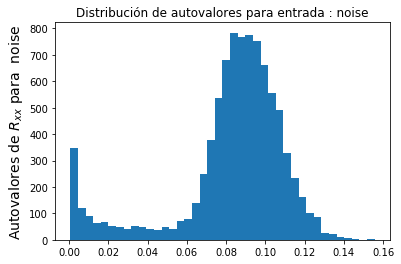

In [0]:
aval = linalg.eigvalsh(R1)
eigenvalues_dist(aval,sound)

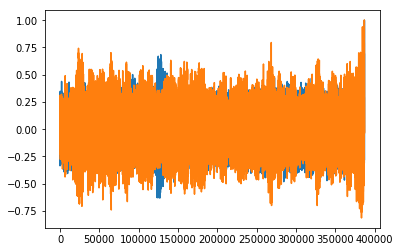

In [0]:
d = d/max(d)
estimado = estimado/max(estimado)
plt.plot(range(len(d)),d)
plt.plot(range(len(estimado)),estimado)
plt.show()

In [0]:
Audio(estimado,rate=fs)

###Entrada Señal de Voz

In [0]:
sound="voice"

audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)


r, p, sigma2d = get_estimations(uZ,dZ)
Jmin = np.zeros(len(Ms))
for i,M in enumerate(Ms):
  r1,R,p1,wo,Jmin[i]= get_filter(r,p,M,sigma2d)



fs de la grabacion  48000 nombre /content/grab_voice.wav
fs de la audio  48000 nombre /content/voice_48k.wav
Calculando R...
Calculando P...


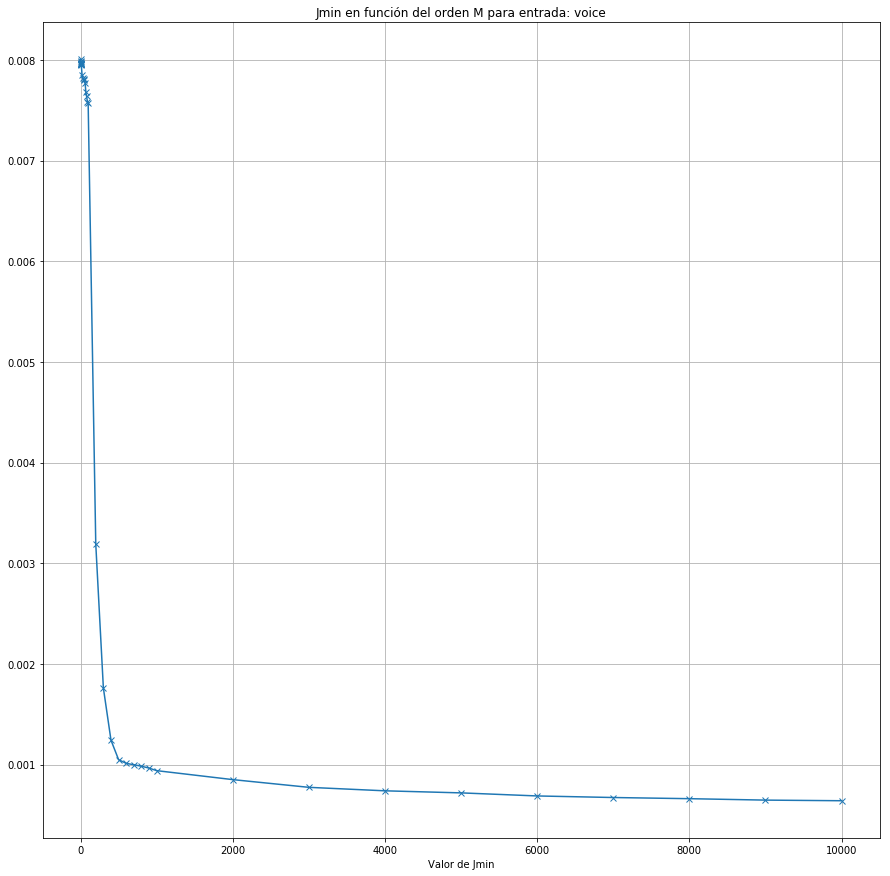

In [0]:
plt.figure(figsize=[15,15])
plt.title("Jmin en función del orden M para entrada: "+ sound)
plt.xlabel("Orden M del filtro")
plt.xlabel("Valor de Jmin")
plt.grid(True)
plt.plot(Ms,Jmin, marker='x')

In [0]:
#ACA ELIJO EL MOPTIMO, CREO QUE HABRIA QUE HARDCODEARLO PARA CADA AUDIO DE ENTRADA
Mopt=Ms[len(Ms)-2]
r1,R1,p1,wo,Jminim= get_filter(r,p,Mopt,sigma2d)
estimado = signal.filtfilt(wo,[1],u)
print("El valor de Epsilon  para el M óptimo es: ",Jminim/sigma2d)

El valor de Epsilon  para el M óptimo es:  0.07937447485181423


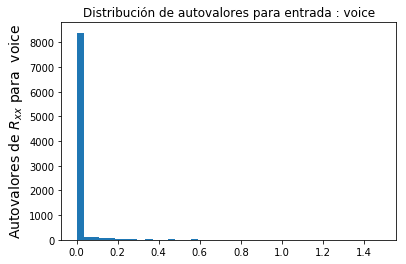

In [0]:
aval = linalg.eigvalsh(R1)
eigenvalues_dist(aval,sound)

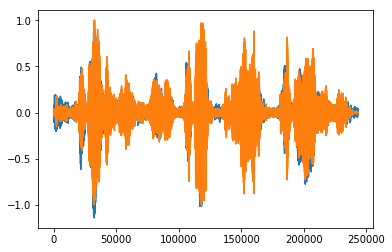

In [0]:
d = d/max(d)
estimado = estimado/max(estimado)
plt.plot(range(len(d)),d)
plt.plot(range(len(estimado)),estimado)
plt.show()

###Entrada Señal de Música

In [0]:
sound="music"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)


r, p, sigma2d = get_estimations(uZ,dZ)
Jmin = np.zeros(len(Ms))
for i,M in enumerate(Ms):
  r1,R,p1,wo,Jmin[i]= get_filter(r,p,M,sigma2d)

estimado = signal.filtfilt(wo,[1],u)


Calculando R...
Calculando P...


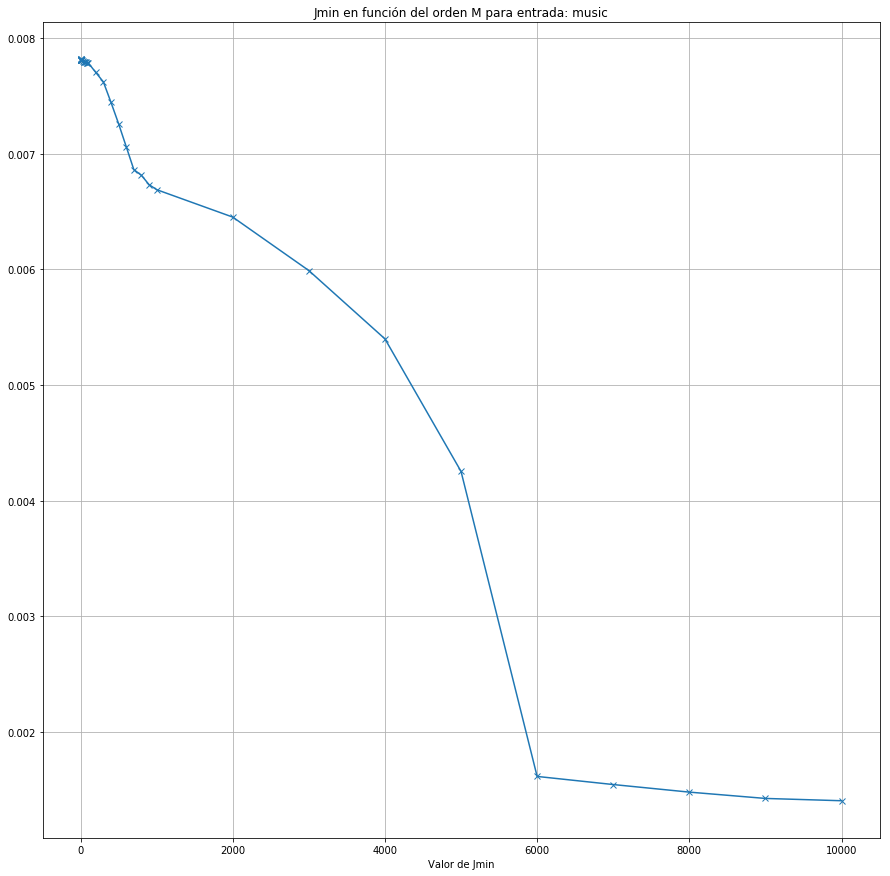

In [0]:
plt.figure(figsize=[15,15])
plt.title("Jmin en función del orden M para entrada: "+ sound)
plt.xlabel("Orden M del filtro")
plt.xlabel("Valor de Jmin")
plt.grid(True)
plt.plot(Ms,Jmin, marker='x')

In [0]:
#ACA ELIJO EL MOPTIMO, CREO QUE HABRIA QUE HARDCODEARLO PARA CADA AUDIO DE ENTRADA
Mopt=Ms[len(Ms)-2]
r1,R1,p1,wo,Jminim= get_filter(r,p,Mopt,sigma2d)
estimado = signal.filtfilt(wo,[1],u)
print("El valor de Epsilon  para el M óptimo es: ",Jminim/sigma2d)

El valor de Epsilon  para el M óptimo es:  0.18218438833306616


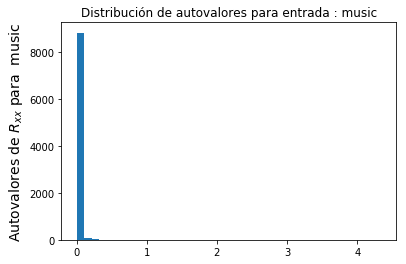

In [0]:
aval = linalg.eigvalsh(R1)
eigenvalues_dist(aval,sound)

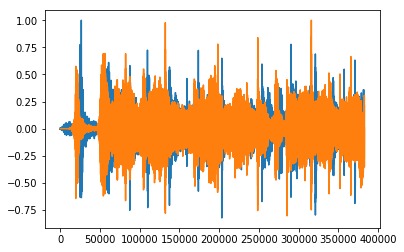

In [0]:
d = d/max(d)
estimado = estimado/max(estimado)
plt.plot(range(len(d)),d)
plt.plot(range(len(estimado)),estimado)
plt.show()

In [0]:
Audio(estimado,rate=fs)